In [1]:
import pandas as pd 

# Load the data
df = pd.read_csv('listings.csv.gz', compression='gzip')

# Delete specified columns
columns_to_delete = ["source", "name", "description", "neighborhood_overview", "picture_url", "host_url", "host_name", "host_location", "host_about", "host_thumbnail_url", "host_picture_url", "host_listings_count", "host_total_listings_count", "neighbourhood", "neighbourhood_group_cleansed", "bathrooms", "minimum_nights_avg_ntm", "maximum_nights_avg_ntm", "calendar_updated", "has_availability", "availability_30", "availability_60", "availability_90", "calendar_last_scraped", "number_of_reviews_ltm", "number_of_reviews_l30d", "last_review", "host_neighbourhood", "license", "calculated_host_listings_count", "calculated_host_listings_count_entire_homes", "calculated_host_listings_count_private_rooms", "calculated_host_listings_count_shared_rooms", "reviews_per_month"]
df = df.drop(columns_to_delete, axis=1)

# Delete rows with missing values in "review_scores_rating", "review_scores_accuracy"
df = df[df['review_scores_rating'].notna() & df['review_scores_accuracy'].notna()]

# Transform price from text to number
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)

# Create new variable "price_per_person"
# If the number of persons is represented by the "accommodates" column
df['price_per_person'] = df['price'] / df['accommodates']

# Adjust latitude and longitude values
df['latitude'] = df['latitude'].apply(lambda x: round(x, 7))
df['longitude'] = df['longitude'].apply(lambda x: round(x, 7))

# Delete outliers in "price"
df = df[(df['price'] < 7000) & (df['price'] < 8000)]

# Delete rows where "minimum_nights" is greater than 15
df = df[df['minimum_nights'] <= 15]

# Delete rows where "availability_365" is less than 10
df = df[df['availability_365'] >= 10]

# Change "review_scores_rating" to float with 2 decimal values
df['review_scores_rating'] = df['review_scores_rating'].apply(lambda x: round(x, 2))

# Save the cleaned data
df.to_csv('cleaned_listings.csv', index=False)



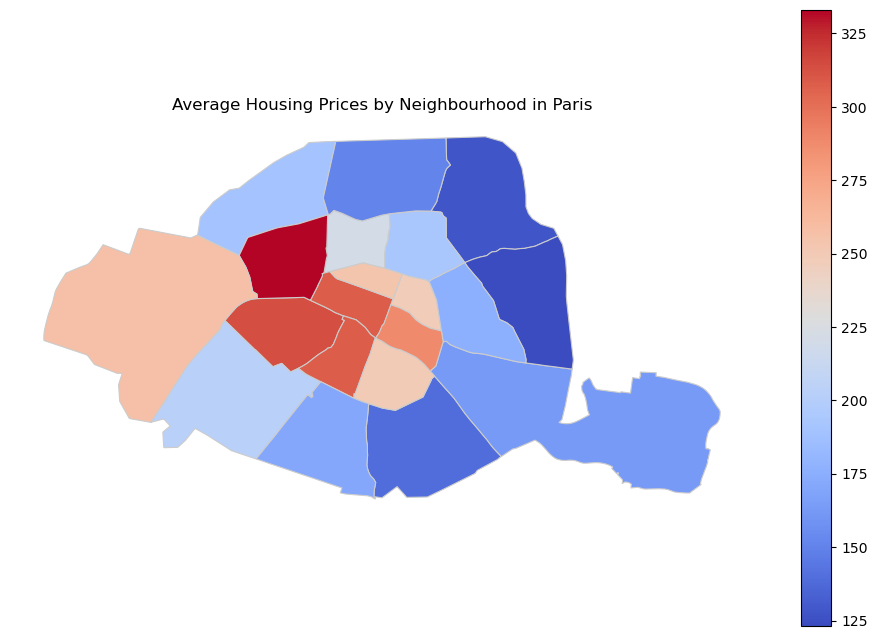

In [2]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

# Load the data
df = pd.read_csv('cleaned_listings.csv')

# Convert the 'price' and 'price_per_person' columns to numeric, errors='coerce' will turn invalid parsing into NaN
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['price_per_person'] = pd.to_numeric(df['price_per_person'], errors='coerce')

# Now drop any rows with NaN in 'price' or 'price_per_person' column (which were originally non-numeric values)
df = df.dropna(subset=['price', 'price_per_person'])

# Create a GeoDataFrame from the cleaned DataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
geo_df = gpd.GeoDataFrame(df, geometry=geometry)

# Set the CRS of geo_df to match that of neighborhoods
geo_df.set_crs("EPSG:4326", inplace=True)

# Load the shapefile of Paris neighborhoods
neighborhoods = gpd.read_file('neighbourhoods.geojson')

# Perform a spatial join between the listings and the neighborhoods
merged_data = gpd.sjoin(geo_df, neighborhoods, how='inner', predicate='within')

# Calculate the average price for each neighborhood
avg_price = merged_data.groupby('neighbourhood').mean(numeric_only=True)['price']


# Merge the average prices with the neighborhoods GeoDataFrame
neighborhoods = neighborhoods.set_index('neighbourhood').join(avg_price)

# Plot the map
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the neighborhoods colored by average price
neighborhoods.plot(column='price', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

# Set the title
ax.set_title('Average Housing Prices by Neighbourhood in Paris')

#To avoid displaying the latitude and longitude axes as they are not useful
plt.axis('off')

# Show the map
plt.show()